# Pima Indians Diabetes Database¶

## Using a Keras based neural network to predict diabetes


This notebook shows how to use a simple Keras based neural network for predicting diabetes. A few things implemented:

- a 3-layer NN 
- model checkpointing / saving
- plotting history

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint

seed = 42
np.random.seed(seed)

In [5]:
# load Pima dataset
pdata = pd.read_csv('../data/diabetes.csv')
pdata.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Let's see what the dataset describes

In [6]:
pdata.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Looks like there are some 0-entries in the dataset. This may or may not be important.

In [7]:
# let's remove the 0-entries for these fields

zero_fields = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

def check_zero_entries(data, fields):
    """ List number of 0-entries in each of the given fields"""
    for field in fields:
        print('field %s: num 0-entries: %d' % (field, len(data.loc[ data[field] == 0, field ])))

check_zero_entries(pdata, zero_fields)

field Glucose: num 0-entries: 5
field BloodPressure: num 0-entries: 35
field SkinThickness: num 0-entries: 227
field Insulin: num 0-entries: 374
field BMI: num 0-entries: 11


As one can see, there are several "0" entries, especially for SkinThickness and Insulin. Atleast some of them (e.g. **Insulin**) matter for diabetes predicition. 

Let us split into Train/Test datasets, and then add back the 0-entries by imputing them from the average.
We don't want to impute for the entire dataset at once, since this would affect the performance on the Test set.


In [9]:
# First - split into Train/Test
from sklearn.model_selection import train_test_split

features = list(pdata.columns.values)
features.remove('Outcome')
print(features)
X = pdata[features]
y = pdata['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print(X_train.shape)
print(X_test.shape)

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
(576, 8)
(192, 8)


In [10]:
# lets fix the 0-entry for a field in the dataset with its mean value
def impute_zero_field(data, field):
    nonzero_vals = data.loc[data[field] != 0, field]
    avg = np.sum(nonzero_vals) / len(nonzero_vals)
    k = len(data.loc[ data[field] == 0, field])   # num of 0-entries
    data.loc[ data[field] == 0, field ] = avg
    print('Field: %s; fixed %d entries with value: %.3f' % (field, k, avg))

In [11]:
# Fix it for Train dataset
for field in zero_fields:
    impute_zero_field(X_train, field)

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Field: Glucose; fixed 4 entries with value: 122.003
Field: BloodPressure; fixed 25 entries with value: 72.846
Field: SkinThickness; fixed 163 entries with value: 29.465
Field: Insulin; fixed 270 entries with value: 158.464
Field: BMI; fixed 8 entries with value: 32.663


In [12]:
# double check for the Train dataset
check_zero_entries(X_train, zero_fields)

field Glucose: num 0-entries: 0
field BloodPressure: num 0-entries: 0
field SkinThickness: num 0-entries: 0
field Insulin: num 0-entries: 0
field BMI: num 0-entries: 0


In [13]:
# Fix for Test dataset
for field in zero_fields:
    impute_zero_field(X_test, field)

Field: Glucose; fixed 1 entries with value: 120.738
Field: BloodPressure; fixed 10 entries with value: 71.071
Field: SkinThickness; fixed 64 entries with value: 28.148
Field: Insulin; fixed 104 entries with value: 145.409
Field: BMI; fixed 3 entries with value: 31.841


In [14]:
# double check for the Test dataset
check_zero_entries(X_test, zero_fields)

field Glucose: num 0-entries: 0
field BloodPressure: num 0-entries: 0
field SkinThickness: num 0-entries: 0
field Insulin: num 0-entries: 0
field BMI: num 0-entries: 0


In [15]:
# Ensure that fieldnames aren't included
X_train = X_train.values
y_train = y_train.values
X_test  = X_test.values
y_test  = y_test.values

### Neural Network model

We define a 3-layer NN model in Keras

- First layer: 12 nodes, with RELU activation
- 2nd layer:   8 nodes,  with RELU activation
- 3rd layer:   output,   with sigmoid activation

In [20]:
EPOCHS = 1000  # num of epochs to test for
BATCH_SIZE = 16

## Create our model
model = Sequential()

# 1st layer: input_dim=8, 12 nodes, RELU
#model.add(Dense(12, input_dim=8, init='uniform', activation='relu'))
model.add(Dense(12, input_dim=8, activation='relu'))
# 2nd layer: 8 nodes, RELU
model.add(Dense(8, activation='relu'))
# output layer: dim=1, activation sigmoid
model.add(Dense(1, activation='sigmoid' ))

# Compile the model
model.compile(loss='binary_crossentropy',   # since we are predicting 0/1
             optimizer='adam',
             metrics=['accuracy'])

# checkpoint: store the best model
ckpt_model = 'pima-weights.best.hdf5'
checkpoint = ModelCheckpoint(ckpt_model, 
                            monitor='val_accuracy',
                            verbose=1,
                            save_best_only=True,
                            mode='max')
callbacks_list = [checkpoint]

print('Starting training:')
# train the model, store the results for plotting
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks_list,
                    verbose=0)

Starting training:

Epoch 00001: val_accuracy improved from -inf to 0.67708, saving model to pima-weights.best.hdf5

Epoch 00002: val_accuracy did not improve from 0.67708

Epoch 00003: val_accuracy did not improve from 0.67708

Epoch 00004: val_accuracy did not improve from 0.67708

Epoch 00005: val_accuracy did not improve from 0.67708

Epoch 00006: val_accuracy did not improve from 0.67708

Epoch 00007: val_accuracy did not improve from 0.67708

Epoch 00008: val_accuracy did not improve from 0.67708

Epoch 00009: val_accuracy did not improve from 0.67708

Epoch 00010: val_accuracy did not improve from 0.67708

Epoch 00011: val_accuracy did not improve from 0.67708

Epoch 00012: val_accuracy did not improve from 0.67708

Epoch 00013: val_accuracy did not improve from 0.67708

Epoch 00014: val_accuracy did not improve from 0.67708

Epoch 00015: val_accuracy did not improve from 0.67708

Epoch 00016: val_accuracy did not improve from 0.67708

Epoch 00017: val_accuracy did not improve f


Epoch 00144: val_accuracy did not improve from 0.71875

Epoch 00145: val_accuracy did not improve from 0.71875

Epoch 00146: val_accuracy did not improve from 0.71875

Epoch 00147: val_accuracy did not improve from 0.71875

Epoch 00148: val_accuracy did not improve from 0.71875

Epoch 00149: val_accuracy did not improve from 0.71875

Epoch 00150: val_accuracy improved from 0.71875 to 0.72396, saving model to pima-weights.best.hdf5

Epoch 00151: val_accuracy did not improve from 0.72396

Epoch 00152: val_accuracy did not improve from 0.72396

Epoch 00153: val_accuracy did not improve from 0.72396

Epoch 00154: val_accuracy did not improve from 0.72396

Epoch 00155: val_accuracy did not improve from 0.72396

Epoch 00156: val_accuracy did not improve from 0.72396

Epoch 00157: val_accuracy did not improve from 0.72396

Epoch 00158: val_accuracy did not improve from 0.72396

Epoch 00159: val_accuracy did not improve from 0.72396

Epoch 00160: val_accuracy did not improve from 0.72396

Epo


Epoch 00287: val_accuracy did not improve from 0.74479

Epoch 00288: val_accuracy did not improve from 0.74479

Epoch 00289: val_accuracy did not improve from 0.74479

Epoch 00290: val_accuracy did not improve from 0.74479

Epoch 00291: val_accuracy did not improve from 0.74479

Epoch 00292: val_accuracy did not improve from 0.74479

Epoch 00293: val_accuracy did not improve from 0.74479

Epoch 00294: val_accuracy did not improve from 0.74479

Epoch 00295: val_accuracy did not improve from 0.74479

Epoch 00296: val_accuracy did not improve from 0.74479

Epoch 00297: val_accuracy did not improve from 0.74479

Epoch 00298: val_accuracy did not improve from 0.74479

Epoch 00299: val_accuracy did not improve from 0.74479

Epoch 00300: val_accuracy did not improve from 0.74479

Epoch 00301: val_accuracy did not improve from 0.74479

Epoch 00302: val_accuracy did not improve from 0.74479

Epoch 00303: val_accuracy did not improve from 0.74479

Epoch 00304: val_accuracy did not improve from 


Epoch 00431: val_accuracy improved from 0.76042 to 0.76562, saving model to pima-weights.best.hdf5

Epoch 00432: val_accuracy did not improve from 0.76562

Epoch 00433: val_accuracy did not improve from 0.76562

Epoch 00434: val_accuracy did not improve from 0.76562

Epoch 00435: val_accuracy did not improve from 0.76562

Epoch 00436: val_accuracy did not improve from 0.76562

Epoch 00437: val_accuracy did not improve from 0.76562

Epoch 00438: val_accuracy did not improve from 0.76562

Epoch 00439: val_accuracy did not improve from 0.76562

Epoch 00440: val_accuracy did not improve from 0.76562

Epoch 00441: val_accuracy did not improve from 0.76562

Epoch 00442: val_accuracy did not improve from 0.76562

Epoch 00443: val_accuracy did not improve from 0.76562

Epoch 00444: val_accuracy improved from 0.76562 to 0.77083, saving model to pima-weights.best.hdf5

Epoch 00445: val_accuracy did not improve from 0.77083

Epoch 00446: val_accuracy did not improve from 0.77083

Epoch 00447: va


Epoch 00576: val_accuracy did not improve from 0.78646

Epoch 00577: val_accuracy did not improve from 0.78646

Epoch 00578: val_accuracy did not improve from 0.78646

Epoch 00579: val_accuracy did not improve from 0.78646

Epoch 00580: val_accuracy did not improve from 0.78646

Epoch 00581: val_accuracy did not improve from 0.78646

Epoch 00582: val_accuracy did not improve from 0.78646

Epoch 00583: val_accuracy did not improve from 0.78646

Epoch 00584: val_accuracy did not improve from 0.78646

Epoch 00585: val_accuracy did not improve from 0.78646

Epoch 00586: val_accuracy did not improve from 0.78646

Epoch 00587: val_accuracy did not improve from 0.78646

Epoch 00588: val_accuracy did not improve from 0.78646

Epoch 00589: val_accuracy did not improve from 0.78646

Epoch 00590: val_accuracy did not improve from 0.78646

Epoch 00591: val_accuracy did not improve from 0.78646

Epoch 00592: val_accuracy did not improve from 0.78646

Epoch 00593: val_accuracy did not improve from 


Epoch 00722: val_accuracy did not improve from 0.79167

Epoch 00723: val_accuracy did not improve from 0.79167

Epoch 00724: val_accuracy did not improve from 0.79167

Epoch 00725: val_accuracy did not improve from 0.79167

Epoch 00726: val_accuracy did not improve from 0.79167

Epoch 00727: val_accuracy did not improve from 0.79167

Epoch 00728: val_accuracy did not improve from 0.79167

Epoch 00729: val_accuracy did not improve from 0.79167

Epoch 00730: val_accuracy did not improve from 0.79167

Epoch 00731: val_accuracy did not improve from 0.79167

Epoch 00732: val_accuracy did not improve from 0.79167

Epoch 00733: val_accuracy did not improve from 0.79167

Epoch 00734: val_accuracy did not improve from 0.79167

Epoch 00735: val_accuracy did not improve from 0.79167

Epoch 00736: val_accuracy did not improve from 0.79167

Epoch 00737: val_accuracy did not improve from 0.79167

Epoch 00738: val_accuracy did not improve from 0.79167

Epoch 00739: val_accuracy did not improve from 


Epoch 00869: val_accuracy did not improve from 0.79167

Epoch 00870: val_accuracy did not improve from 0.79167

Epoch 00871: val_accuracy did not improve from 0.79167

Epoch 00872: val_accuracy did not improve from 0.79167

Epoch 00873: val_accuracy did not improve from 0.79167

Epoch 00874: val_accuracy did not improve from 0.79167

Epoch 00875: val_accuracy did not improve from 0.79167

Epoch 00876: val_accuracy did not improve from 0.79167

Epoch 00877: val_accuracy did not improve from 0.79167

Epoch 00878: val_accuracy did not improve from 0.79167

Epoch 00879: val_accuracy did not improve from 0.79167

Epoch 00880: val_accuracy improved from 0.79167 to 0.79688, saving model to pima-weights.best.hdf5

Epoch 00881: val_accuracy did not improve from 0.79688

Epoch 00882: val_accuracy did not improve from 0.79688

Epoch 00883: val_accuracy did not improve from 0.79688

Epoch 00884: val_accuracy did not improve from 0.79688

Epoch 00885: val_accuracy did not improve from 0.79688

Epo

In [36]:
history.history['loss']

[40.70600488450792,
 15.202654474311405,
 1.4580881413486269,
 0.9153949518998464,
 0.8315618518326018,
 0.7847089163131185,
 0.7514855977561739,
 0.7186485975980759,
 0.6863324344158173,
 0.6705589923593733,
 0.6525948618849119,
 0.6483249093095461,
 0.6364352256059647,
 0.628313278986348,
 0.6312584421700902,
 0.6271288626723819,
 0.6272147794564565,
 0.6235967146025764,
 0.6221832086642584,
 0.6142895138925977,
 0.609770385755433,
 0.6116004271639718,
 0.607927906844351,
 0.6203214567568567,
 0.6109149497416284,
 0.6029359102249146,
 0.6021839628616968,
 0.5974391740229394,
 0.6010695546865463,
 0.6031946034895049,
 0.6059282024701437,
 0.592207171022892,
 0.5911779387129678,
 0.5854282238417201,
 0.5942812843455209,
 0.5990643642014928,
 0.5993820304671923,
 0.5895668913920721,
 0.5872190900974803,
 0.5875927731394768,
 0.5874039323793517,
 0.5831225141882896,
 0.5824946289261183,
 0.5861983026067416,
 0.5940210794409116,
 0.5802539355225034,
 0.5744787156581879,
 0.580129191279411

In [27]:
%matplotlib inline

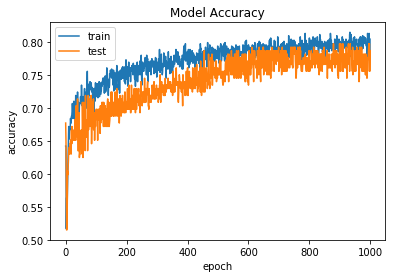

In [33]:
# Model accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

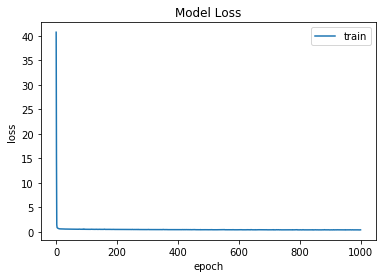

In [35]:
# Model Losss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [29]:
# print final accuracy
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 78.65%


So we see several things:

    - We get accuracy is  about **78%**, which is decent, not great
    - after about 300 epochs, the model does not really improve.
    - After about 500 epochs, the training loss starts to increase, which indicates overfitting

A few things could be done to improve the results:

- Different model architecture (num of nodes, etc)
- Dropout
- Adaptive learning rate